In [11]:
from matplotlib import pyplot as plt
import mpl_scatter_density
%matplotlib inline

import numpy as np

import pandas as pd

from gadget.pygadget import Simulation

In [12]:
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [13]:
from rockstar.models import RockstarHalo

In [14]:
base_halo = RockstarHalo.objects.filter(hid='1330')[0]
base_halo

print(base_halo.rvir)

203.332


In [15]:
#basedir = '/media/DATA/simulations/hog/media/gadget/run/457_70495_DM_L12/'
basedir = '/media/lbignone/_data/lbignone/hog/media/gadget/run/465_1330_DM_12/'
snapnum = 64
fname = basedir + 'snapshot_{:03d}'.format(snapnum)

snap = Simulation(fname, multiple_files=True, pot=True)

dm_pos = snap.read_block('pos', 'halo', iter_files=False, all_files=True)
bndry_pos = snap.read_block('pos', 'disk', iter_files=False, all_files=True)

In [16]:
len(bndry_pos)

780577

In [17]:
basedir_base = '/home/lbignone/simulations/lgzoom/out512/'
snapnum_base = 14
fname_base = basedir_base + 'snapshot_{:03d}'.format(snapnum_base)

snap_base = Simulation(fname_base, multiple_files=True, pot=False)

base_pos = snap_base.read_block('pos', 'halo', iter_files=False, all_files=True)

In [18]:
# Load rockstar data for central halo

columns = ['hid', 'descid', 'mvir', 'vmax', 'vrms', 'rvir', 'rs', 'np', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'jx',
           'jy', 'jz','spin', 'rs_klypin', 'mvir_all', 'm200b', 'm200c', 'm500c', 'm2500c', 'xoff', 'voff',
           'spin_bullock', 'b_to_a', 'c_to_a', 'ax', 'ay', 'az', 'b_to_a_500c', 'pid',]

rockstar_fname = basedir + 'halos/out_{:d}.list'.format(snapnum)

halos = np.genfromtxt(rockstar_fname, names=columns)
halos = pd.DataFrame(halos)

central_i = halos['rvir'].argmax()

central = halos.iloc[central_i]

In [19]:
# compute bndry particles distance to halo centre

bndry_r = bndry_pos - central[['x', 'y', 'z']] * 1000
bndry_distance = np.sqrt((bndry_r**2).sum(axis=1))

30754 207.043


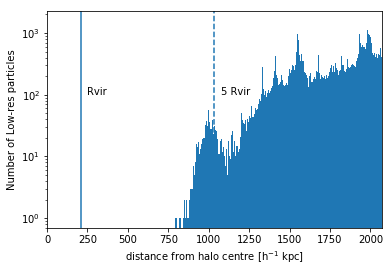

In [20]:
# Plot number of bndry particles as a function of halo distance

rvir = central['rvir']
print(central.name, rvir)

bins = np.linspace(0, 10*rvir, 1000)

h = plt.hist(bndry_distance, bins=bins)

plt.axvline(rvir, linestyle='-')
plt.axvline(5*rvir, linestyle='--')

plt.yscale('log')

plt.xlim(0, 10*rvir)

# set labels
text_margin = 40
text_y = 100
rotation = 0
plt.text(rvir+text_margin, text_y, 'Rvir', rotation=rotation)
plt.text(5*rvir+text_margin, text_y, '5 Rvir', rotation=rotation)

plt.ylabel(r'Number of Low-res particles')
plt.xlabel(r'distance from halo centre [h$^{-1}$ kpc]')

In [21]:
# Plot Hres and Lres halos

def plot_hres_lres():

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 2, 1, projection='scatter_density')

    xc = central.x * 1000
    yc = central.y * 1000
    zc = central.z * 1000
    
    r = dm_pos[['x', 'y', 'z']] - np.array([xc, yc, zc])
    d2 = (r**2).sum(axis=1)
    mask = d2 < (rtb*rvir)**2
    
    x = r[mask]['x']
    y = r[mask]['y']
    
    ax.scatter_density(x, y, norm=norm)

    ax.set_xlim(-rtb*rvir, +rtb*rvir)
    ax.set_ylim(-rtb*rvir, +rtb*rvir)

    ax.set_aspect('equal')

    #----------------------------------------------------------------

    ax = fig.add_subplot(1, 2, 2, projection='scatter_density')

    xc = base_halo.x * 1000
    yc = base_halo.y * 1000
    zc = base_halo.z * 1000
    
    r = base_pos[['x', 'y', 'z']] - np.array([xc, yc, zc])
    d2 = (r**2).sum(axis=1)
    mask = d2 < (rtb*rvir)**2

    x = r[mask]['x']
    y = r[mask]['y']
    
    ax.scatter_density(x, y, norm=norm)
    
    circle1 = plt.Circle((0, 0), base_halo.rvir, color='r', fill=False)
    circle2 = plt.Circle((0, 0), 5*base_halo.rvir, color='r', fill=False)
    circle3 = plt.Circle((0, 0), 10*base_halo.rvir, color='r', fill=False)
    
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)

    ax.set_xlim(-rtb*rvir, +rtb*rvir)
    ax.set_ylim(-rtb*rvir, +rtb*rvir)

    ax.set_aspect('equal')

    plt.tight_layout()

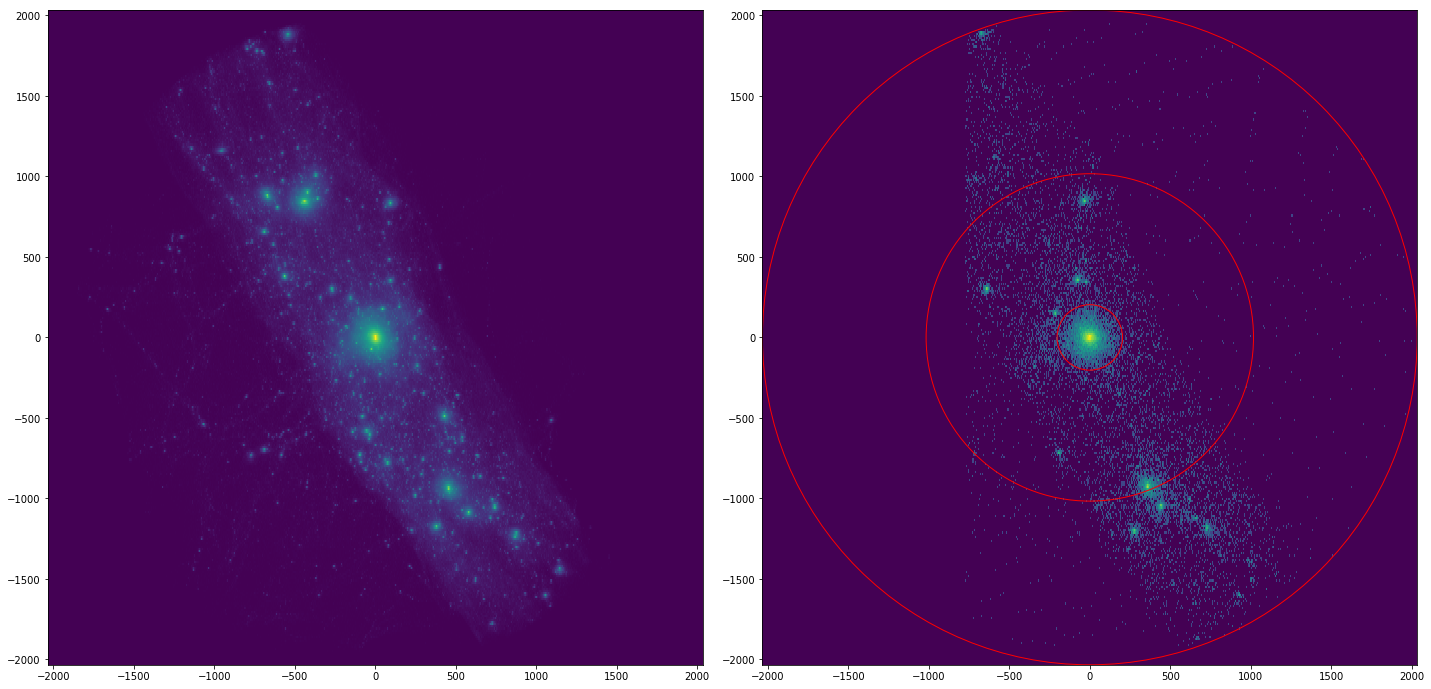

In [22]:
norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

rvir = base_halo.rvir
rtb = 10

plot_hres_lres()

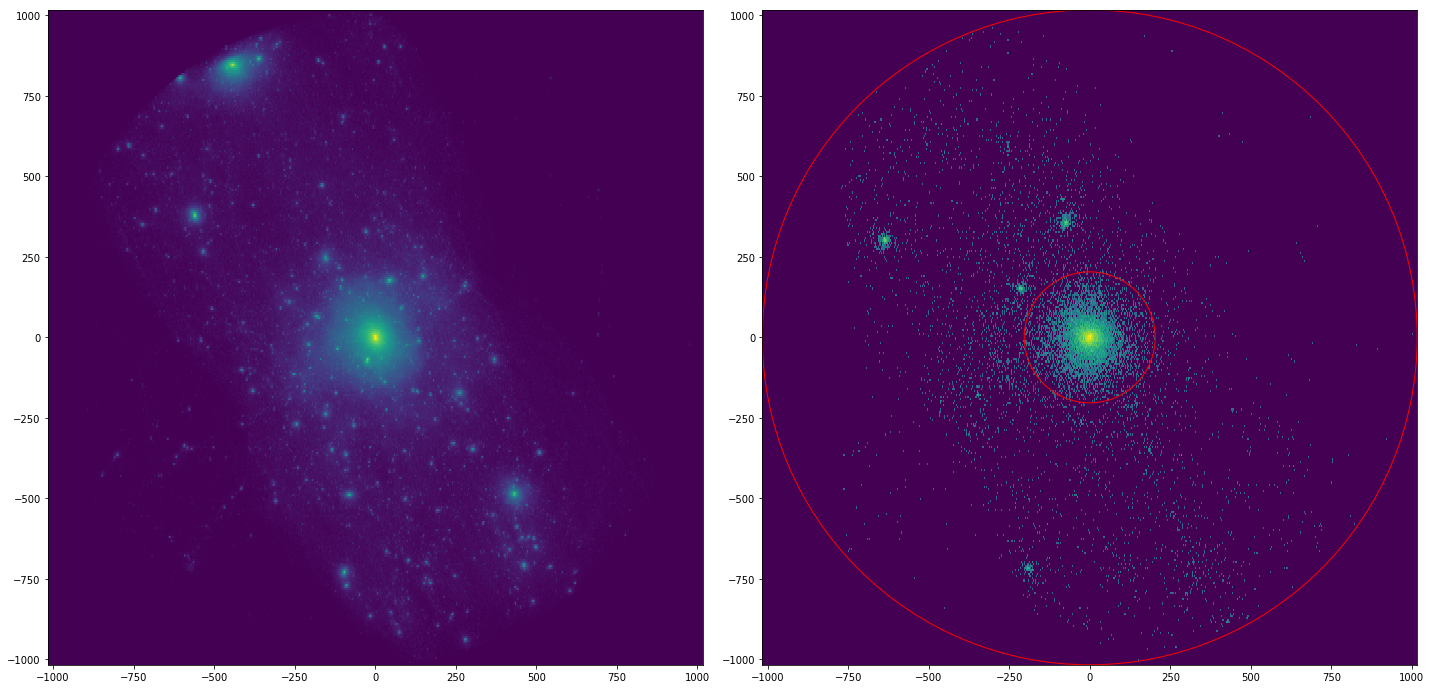

In [23]:
rvir = base_halo.rvir
rtb = 5

plot_hres_lres()

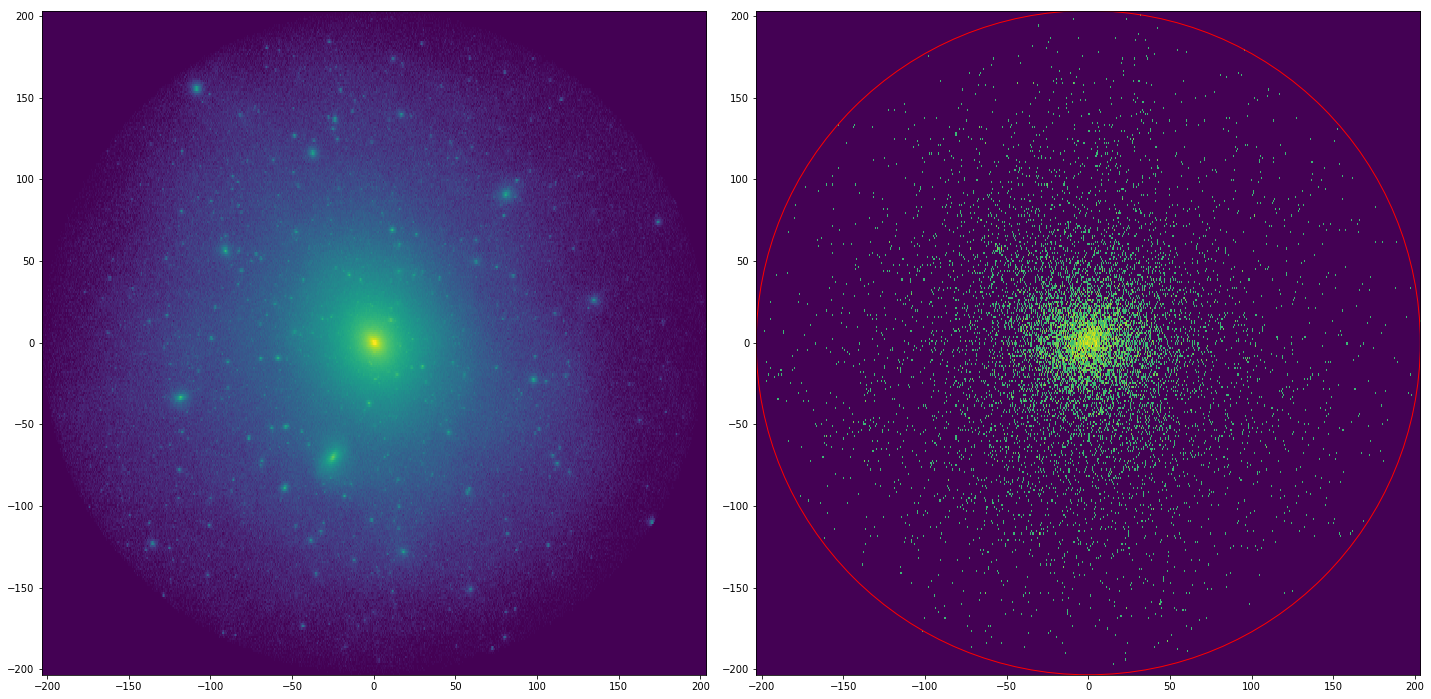

In [24]:
rvir = base_halo.rvir
rtb = 1

plot_hres_lres()

In [25]:
# compare Hres an Lres rvir and mvir

drvir = 100 * (central['rvir'] -  base_halo.rvir) / base_halo.rvir
dmvir = 100 * (central['mvir'] -  base_halo.mvir) / base_halo.mvir

print('      Hres vs Lres')
print('Rvir:', central['rvir'], 'vs', base_halo.rvir, '       {:+.2f}%'.format(drvir))
print('Mvir:', '{:.2e}'.format(central['mvir']), 'vs', '{:.2e}'.format(base_halo.mvir), '     {:+.2f}%'.format(dmvir))

      Hres vs Lres
Rvir: 207.043 vs 203.332        +1.83%
Mvir: 1.07e+12 vs 1.01e+12      +5.54%
